#                               Seam carving - proširivanje slike

Za proširivanje slike postoje dve osnovne strategije.

##                                                 Prva strategija

Prva strategija podrazumeva da se odgovarajući broj puta ponovi sledeća procedura:
1) nađi traku najmanje energije
2) pored trake najmanje energije postavi traku čija će vrednost biti aritmetička sredina traka susednih od trake najmanje energije
Prednost ove procedure je jednostavna implementacija.
Mana je što se može desiti da se ista traka izabere više puta, što bi upropastilo sliku.

<Figure size 640x480 with 0 Axes>

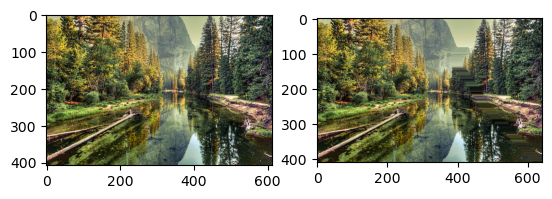

In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

## funkcija koja prosiruje sliku upotrebom prve strategije
## kod je veoma slican funkciji za suzavanje slike
def seam_carving_enlarge(image, target_width):
    current_width = image.size[0]
    current_height = image.size[1]
    image = np.array(image).astype(np.float32)
    
    while current_width < target_width:
        sx = ndimage.sobel(image, axis = 0, mode='constant')
        sy = ndimage.sobel(image, axis = 1, mode='constant')
        sobel = np.absolute(sx) + np.absolute(sy)
        energy = sobel.sum(axis = 2)
        
        M = np.zeros([current_height, current_width])
        # prvi red je energija piksela iz prvog reda
        M[0] = energy[0]
        for i in range(1, current_height):
            M[i, 0] = energy[i, 0] + min(M[i - 1, 0], M[i - 1, 1])
            M[i, current_width - 1] = energy[i, current_width - 1] + min(M[i - 1, current_width - 1], M[i - 1, current_width - 2])
            for j in range(1, current_width - 1):
                M[i, j] = energy[i, j] + min(M[i - 1, j - 1], min(M[i - 1, j], M[i - 1, j + 1]))
        seam = np.zeros([current_height]).astype(int)
        m = 0
        for j in range(1, current_width):
            if M[current_height - 1, 0] > M[current_height - 1, j]:
                m = j
            seam[current_height - 1] = m
        
        for i in reversed(range(1, current_height)):
            j = seam[i]
            if j == 0:
                # posmatramo samo desnog suseda
                if M[i - 1, j] < M[i - 1, j + 1]:
                    seam[i - 1] = j
                else:
                    seam[i - 1] = j + 1
            elif j == current_width - 1:
                # posmatramo samo levog suseda
                if M[i - 1, j] < M[i - 1, j - 1]:
                    seam[i - 1] = j
                else:
                    seam[i - 1] = j - 1
            else:
                # posmatramo oba suseda
                m = min(M[i - 1, j - 1], min(M[i - 1, j], M[i - 1, j + 1]))
                if m == M[i - 1, j - 1]:
                    seam[i - 1] = j - 1
                elif m == M[i - 1, j]:
                    seam[i - 1] = j
                else:
                    seam[i - 1] = j + 1
        
        # sustinska razlika u odnosu na funkciju za skracivanje nastaje ovde
        # dodajemo traku, ali vrednost svakog piksela ce biti aritmeticka sredina
        # susednih piksela u odnosu na traku najmanje energije
        new_image = np.zeros([current_height, current_width + 1, 3]).astype(np.float32)
        for i in range(current_height):
            for j in range(current_width + 1):
                if j < seam[i]:
                    new_image[i, j] = image[i, j]
                elif j > seam[i] + 1:
                    new_image[i, j] = image[i, j - 1]
                elif j == seam[i]:
                    if j == 0:
                        new_image[i, j] = image[i, seam[i] + 1] / 2
                    elif j == current_width - 1:
                        new_image[i, j] = image[i, seam[i] - 1] / 2
                    else:
                        new_image[i, j] = (image[i, seam[i] - 1] + image[i, seam[i] + 1]) / 2
                else:
                    new_image[i, j] = image[i, seam[i]]
        image = new_image
        current_width += 1
        
    return image

image = Image.open('assets/nature2.jpg')
t = seam_carving_enlarge(image, image.size[0] + 30).astype(np.uint8)

#plt.imshow(t)
plt.figure()

f, axarr = plt.subplots(1, 2) 

axarr[0].imshow(image)
axarr[1].imshow(t)

Ovde se primećuje glavna mana ovog pristupa: budući da se ista traka birala više puta, slika izgleda neprirodno. Zbog toga je smišljen drugi pristup.

##                                              Druga strategija

Druga strategija podrazumeva da se iz slike najpre onoliko traka koliko bi trebalo dodati, a onda da se te trake dupliraju. Teža je implementacija ove strategije, ali je zato rezultat češće prirodniji nego u prvoj strategiji.

In [2]:
# funkcija za nalazenje K traka najmanje energije
# K = target_width - current_width
def find_seams(image, target_width):
    current_width = image.size[0]
    current_height = image.size[1]
    K = target_width - current_width
    image = np.array(image).astype(np.float32)
    ## trake smestamo u matricu dimenzija current_height x K
    ## tako da vazi seam[i, k] = j je piksel (i, j) sa trake k
    ## drugim recima, kolone matrice predstavljaju vertikalne trake
    seam = np.zeros([current_height, K]).astype(int)
    k = 0
    
    ## slicno kao i pre se racunaju trake
    while k != K:
        sx = ndimage.sobel(image, axis = 0, mode='constant')
        sy = ndimage.sobel(image, axis = 1, mode='constant')
        sobel = np.absolute(sx) + np.absolute(sy)
        energy = sobel.sum(axis = 2)
        
        M = np.zeros([current_height, current_width])
        # prvi red je energija piksela iz prvog reda
        M[0] = energy[0]
        for i in range(1, current_height):
            M[i, 0] = energy[i, 0] + min(M[i - 1, 0], M[i - 1, 1])
            M[i, current_width - 1] = energy[i, current_width - 1] + min(M[i - 1, current_width - 1], M[i - 1, current_width - 2])
            for j in range(1, current_width - 1):
                M[i, j] = energy[i, j] + min(M[i - 1, j - 1], min(M[i - 1, j], M[i - 1, j + 1]))
        
        # racunamo trenutnu traku
        m = 0
        for j in range(1, current_width):
            if M[current_height - 1, 0] > M[current_height - 1, j]:
                m = j
            seam[current_height - 1, k] = m
        
        for i in reversed(range(1, current_height)):
            j = seam[i, k]
            if j == 0:
                # posmatramo samo desnog suseda
                if M[i - 1, j] < M[i - 1, j + 1]:
                    seam[i - 1, k] = j
                else:
                    seam[i - 1, k] = j + 1
            elif j == current_width - 1:
                # posmatramo samo levog suseda
                if M[i - 1, j] < M[i - 1, j - 1]:
                    seam[i - 1, k] = j
                else:
                    seam[i - 1, k] = j - 1
            else:
                # posmatramo oba suseda
                m = min(M[i - 1, j - 1], min(M[i - 1, j], M[i - 1, j + 1]))
                if m == M[i - 1, j - 1]:
                    seam[i - 1, k] = j - 1
                elif m == M[i - 1, j]:
                    seam[i - 1, k] = j
                else:
                    seam[i - 1, k] = j + 1
        
        new_image = np.zeros([current_height, current_width - 1, 3]).astype(np.float32)
        for i in range(current_height):
            for j in range(current_width):
                if j < seam[i, k]:
                    new_image[i, j] = image[i, j]
                elif j > seam[i, k]:
                    new_image[i, j - 1] = image[i, j]
                else:
                    continue
                    
        image = new_image
        current_width -= 1
        k += 1
        
    return seam

image = Image.open('assets/nature2.jpg')
seams = find_seams(image, image.size[0] + 30)
seams

array([[401, 401, 401, ..., 337, 385, 384],
       [401, 401, 401, ..., 337, 385, 383],
       [401, 401, 401, ..., 338, 385, 384],
       ...,
       [609, 608, 607, ..., 582, 581, 580],
       [610, 609, 608, ..., 583, 582, 581],
       [611, 610, 609, ..., 584, 583, 582]])

Za svaki piksel originalne slike, može se odrediti da li će on biti udvostručen ili ne. Piksel će biti udvostručen ako mu odgovara neka od uklonjenih traka. Možemo svakom pikselu trake pridružiti piksel originalne slike na jedinstven način.

In [3]:
# funkcija koja racuna koordinate druge trake
# u originalnoj slici (pre izbacivanja prve trake)
def return_seam(x1, x2):
    if x2 < x1:
        return x2
    else:
        return x2 + 1

K = 30
for i in range(image.size[1]):
    # unazad imitiramo vracanje jedne po jedne trake
    for k in range(1, K):
        for j in reversed(range(k, K)):
            seams[i, j] = return_seam(seams[i, j - k], seams[i, j])
seams

array([[401, 402, 403, ..., 337, 398, 387],
       [401, 402, 403, ..., 337, 397, 385],
       [401, 402, 403, ..., 338, 388, 387],
       ...,
       [609, 608, 607, ..., 582, 581, 580],
       [610, 609, 608, ..., 583, 582, 581],
       [611, 610, 609, ..., 584, 583, 582]])

Označićemo trake koje ćemo duplirati na slici crvenom bojom.

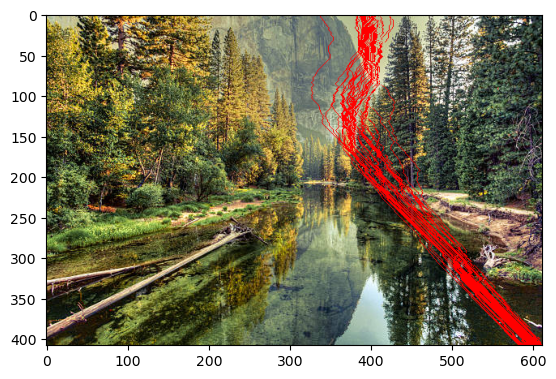

In [4]:
t = image
for i in range(t.size[1]):
    for k in range(K):
        t.putpixel((seams[i, k], i), (255, 0, 0))

plt.imshow(t)

In [5]:
# sortiramo vrste matrice seams, kako bismo efikasnije (i lakse) sproveli vracanje
for i in range(image.size[1]):
    seams[i].sort()
seams

array([[337, 381, 385, ..., 406, 423, 423],
       [337, 381, 385, ..., 408, 423, 424],
       [338, 382, 384, ..., 410, 424, 424],
       ...,
       [580, 581, 582, ..., 608, 609, 610],
       [581, 582, 583, ..., 608, 609, 610],
       [582, 583, 584, ..., 609, 610, 611]])

<Figure size 640x480 with 0 Axes>

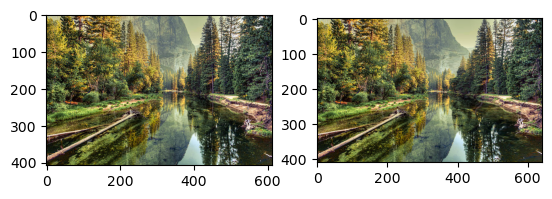

In [6]:
current_height = t.size[1]
current_width = t.size[0]
new_image = np.zeros([current_height, current_width + K, 3]).astype(np.float32)
image = np.array(Image.open('assets/nature2.jpg')).astype(np.float32)

# dupliramo jednu po jednu traku
for i in range(current_height):
    # idemo od 0 do seams[i, 0], pa do seams[i, 1]...
    for j in range(seams[i, 0] + 1):
        new_image[i, j] = image[i, j]
    if seams[i, 0] == 0:
        new_image[i, seams[i, 0] + 1] = image[i, seams[i, 0]] / 2
    else:
        new_image[i, seams[i, 0] + 1] = (image[i, seams[i, 0] - 1] + image[i, seams[i, 0] + 1]) / 2
    
    for k in range(K - 1):
        for j in range(seams[i, k] + k + 2, seams[i, k + 1] + k + 2):
            new_image[i, j] = image[i, j - k - 1]
            
        if seams[i, k + 1] == current_width - 1:
            new_image[i, seams[i, k + 1] + k + 2] = image[i, current_width - 1] / 2
        else:
            new_image[i, seams[i, k + 1] + k + 2] = (image[i, seams[i, k + 1] - 1] + image[i, seams[i, k + 1] + 1]) / 2
        
    for j in range(seams[i, K - 1] + K + 1, current_width + K):
        new_image[i, j] = image[i, j - K - 2]


image = (image * 255 / np.max(image)).astype(np.uint8)
new_image = (new_image * 255 / np.max(new_image)).astype(np.uint8)
        
plt.figure()

f, axarr = plt.subplots(1, 2) 

axarr[0].imshow(image)
axarr[1].imshow(new_image)

Ipak, postoje i ograničenja i ovog pristupa.
Prvo ograničenje se sastoji u tome što nije moguće sliku proširiti na širinu veću od njene dvostruke. To je posledica rada algoritma - on prvo skine onoliko traka koliko je potrebno dodati, a potom "vraća" te trake. Ukoliko je potrebno dodati više traka nego što je širina slike, neće imati odakle trake da se skinu. Jedno rešenje za to je da se algoritam pokrene više puta i deo-po-deo proširuje.
Drugo ograničenje je što, kako se K povećava, slika liči sve više na onu koja se dobija skaliranjem. Takođe, može se pojaviti određena zamućenost u slici. Pokrenućemo algoritam nad istom slikom kako bismo je proširili za petinu, trećinu, polovinu i 75% svoje veličine.

In [7]:
## funkcije koje obuhvataju ceo proces uvecavanja slike preko strategije 2

def find_seams(image, target_width, K):
    current_width = image.size[0]
    current_height = image.size[1]
    K = target_width - current_width
    image = np.array(image).astype(np.float32)
    seam = np.zeros([current_height, K]).astype(int)
    k = 0
    
    while k != K:
        sx = ndimage.sobel(image, axis = 0, mode='constant')
        sy = ndimage.sobel(image, axis = 1, mode='constant')
        sobel = np.absolute(sx) + np.absolute(sy)
        energy = sobel.sum(axis = 2)
        
        M = np.zeros([current_height, current_width])
        # prvi red je energija piksela iz prvog reda
        M[0] = energy[0]
        for i in range(1, current_height):
            M[i, 0] = energy[i, 0] + min(M[i - 1, 0], M[i - 1, 1])
            M[i, current_width - 1] = energy[i, current_width - 1] + min(M[i - 1, current_width - 1], M[i - 1, current_width - 2])
            for j in range(1, current_width - 1):
                M[i, j] = energy[i, j] + min(M[i - 1, j - 1], min(M[i - 1, j], M[i - 1, j + 1]))
        
        # racunamo trenutnu traku
        m = 0
        for j in range(1, current_width):
            if M[current_height - 1, 0] > M[current_height - 1, j]:
                m = j
            seam[current_height - 1, k] = m
        
        for i in reversed(range(1, current_height)):
            j = seam[i, k]
            if j == 0:
                # posmatramo samo desnog suseda
                if M[i - 1, j] < M[i - 1, j + 1]:
                    seam[i - 1, k] = j
                else:
                    seam[i - 1, k] = j + 1
            elif j == current_width - 1:
                # posmatramo samo levog suseda
                if M[i - 1, j] < M[i - 1, j - 1]:
                    seam[i - 1, k] = j
                else:
                    seam[i - 1, k] = j - 1
            else:
                # posmatramo oba suseda
                m = min(M[i - 1, j - 1], min(M[i - 1, j], M[i - 1, j + 1]))
                if m == M[i - 1, j - 1]:
                    seam[i - 1, k] = j - 1
                elif m == M[i - 1, j]:
                    seam[i - 1, k] = j
                else:
                    seam[i - 1, k] = j + 1
        
        new_image = np.zeros([current_height, current_width - 1, 3]).astype(np.float32)
        for i in range(current_height):
            for j in range(current_width):
                if j < seam[i, k]:
                    new_image[i, j] = image[i, j]
                elif j > seam[i, k]:
                    new_image[i, j - 1] = image[i, j]
                else:
                    continue
                    
        image = new_image
        current_width -= 1
        k += 1
        
    return seam

def return_seam(x1, x2):
    if x2 < x1:
        return x2
    else:
        return x2 + 1

def return_seams(seams, K, height):
    for i in range(height):
        # unazad imitiramo vracanje jedne po jedne trake
        for k in range(1, K):
            for j in reversed(range(k, K)):
                seams[i, j] = return_seam(seams[i, j - k], seams[i, j])
    return seams


def seam_carving_enlarge(image, target_width):
    K = target_width - image.size[0]
    current_height = image.size[1]
    current_width = image.size[0]
    seams = find_seams(image, target_width, K)
    seams = return_seams(seams, K, current_height)
    
    for i in range(image.size[1]):
        seams[i].sort()


    new_image = np.zeros([current_height, current_width + K, 3]).astype(np.float32)
    image = np.array(image).astype(np.float32)
    
    for i in range(current_height):
    # idemo od 0 do seams[i, 0], pa do seams[i, 1]...
        for j in range(seams[i, 0] + 1):
            new_image[i, j] = image[i, j]
       
        if seams[i, 0] == 0:
            new_image[i, seams[i, 0] + 1] = image[i, seams[i, 0]] / 2
        else:
            new_image[i, seams[i, 0] + 1] = (image[i, seams[i, 0] - 1] + image[i, seams[i, 0] + 1]) / 2
    
        for k in range(K - 1):
            for j in range(seams[i, k] + k + 2, seams[i, k + 1] + k + 2):
                new_image[i, j] = image[i, j - k - 1]
            
            if seams[i, k + 1] == current_width - 1:
                new_image[i, seams[i, k + 1] + k + 2] = image[i, current_width - 1] / 2
            else:
                new_image[i, seams[i, k + 1] + k + 2] = (image[i, seams[i, k + 1] - 1] + image[i, seams[i, k + 1] + 1]) / 2
        
        for j in range(seams[i, K - 1] + K + 1, current_width + K):
            new_image[i, j] = image[i, j - K - 2]
        
    return new_image

<Figure size 640x480 with 0 Axes>

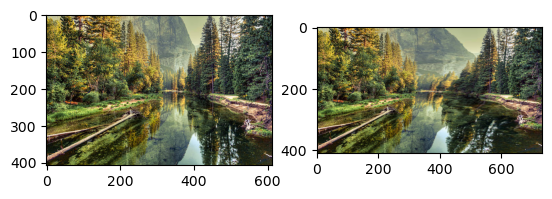

In [8]:
image = Image.open('assets/nature2.jpg')
img = seam_carving_enlarge(image, image.size[0] + (image.size[0] // 5))
new_image = (img * 255 / np.max(img)).astype(np.uint8)

plt.figure()

f, axarr = plt.subplots(1, 2) 

axarr[0].imshow(image)
axarr[1].imshow(new_image)

<Figure size 640x480 with 0 Axes>

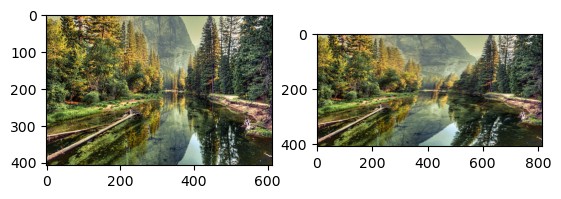

In [9]:
image = Image.open('assets/nature2.jpg')
img = seam_carving_enlarge(image, image.size[0] + (image.size[0] // 3))
new_image = (img * 255 / np.max(img)).astype(np.uint8)

plt.figure()

f, axarr = plt.subplots(1, 2) 

axarr[0].imshow(image)
axarr[1].imshow(new_image)

<Figure size 640x480 with 0 Axes>

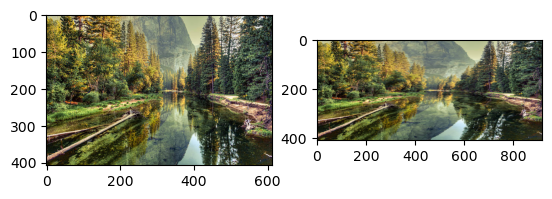

In [10]:
image = Image.open('assets/nature2.jpg')
img = seam_carving_enlarge(image, image.size[0] + (image.size[0] // 2))
new_image = (img * 255 / np.max(img)).astype(np.uint8)

plt.figure()

f, axarr = plt.subplots(1, 2) 

axarr[0].imshow(image)
axarr[1].imshow(new_image)

<Figure size 640x480 with 0 Axes>

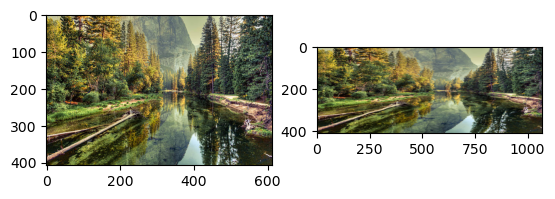

In [12]:
image = Image.open('assets/nature2.jpg')
img = seam_carving_enlarge(image, image.size[0] + ((3 * image.size[0]) // 4))
new_image = (img * 255 / np.max(img)).astype(np.uint8)

plt.figure()

f, axarr = plt.subplots(1, 2) 

axarr[0].imshow(image)
axarr[1].imshow(new_image)